In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.model_selection import train_test_split 
import sklearn.metrics as skm
import time

In [48]:
file_path = r'C:\Users\M-Ali\Downloads\Compressed\mnist_train.csv'

data = np.loadtxt(open(file_path, 'rb'), delimiter=",", skiprows=1)

labels = data[:40000,0]
data  = data[:40000,1:]
data = data/np.max(data)

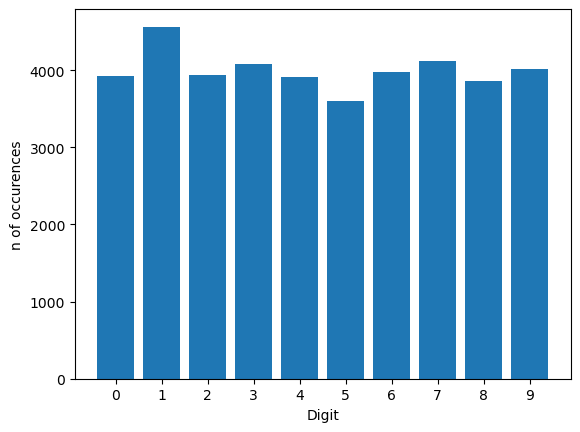

In [49]:
catcount = np.unique(labels,return_counts=True)
plt.bar(catcount[0],catcount[1])
plt.xlabel("Digit")
plt.ylabel("n of occurences")
plt.xticks(range(10))
plt.show()

In [50]:
where7  = np.where(labels==7)[0]
N2remove = where7.shape[0] - 500

remove7s = np.random.choice(where7,size=N2remove,replace=False)

print(data.shape)
print(labels.shape)

data = np.delete(data,remove7s,axis=0)
labels = np.delete(labels,remove7s)
print("after shape")
print(data.shape)
print(labels.shape)

(40000, 784)
(40000,)
after shape
(36375, 784)
(36375,)


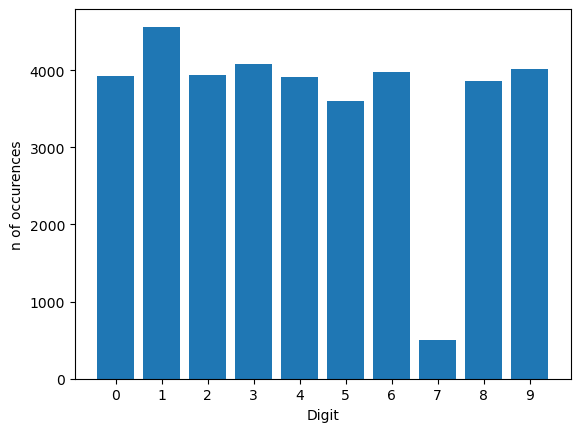

In [51]:
catcount = np.unique(labels,return_counts=True)
plt.bar(catcount[0],catcount[1])
plt.xlabel("Digit")
plt.ylabel("n of occurences")
plt.xticks(range(10))
plt.show()

In [52]:
dataT  = torch.tensor(data).float()
labels = torch.tensor(labels).long()

train_d,test_d,train_l,test_l = train_test_split(dataT,labels,test_size=.2)

trainD = TensorDataset(train_d,train_l)
testD = TensorDataset(test_d,test_l)
batchsize=32
train_loader = DataLoader(trainD,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader= DataLoader(testD,batch_size=testD.tensors[0].shape[0])

In [53]:
def CreateMnist():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)
        def forward(self,x):
            x  = self.input(x)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
            return x

    
    net = MnistNet()
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=.01)
    return net,lossfun,optimizer

In [54]:
def TraintheModel():
    timeInfunction = time.process_time()
    numEpochs = 10
    
    net,lossfun,optimizer = CreateMnist()
    
    trainAcc = []
    losses = np.zeros(numEpochs)
    testAcc = []

    for epoch in range(numEpochs):
        batchLoss = []
        batchAcc = []
        for X,y in train_loader:
            yhat = net(X)

            loss = lossfun(yhat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100 * torch.mean((torch.argmax(yhat, axis=1) == y).float()).item())
        losses[epoch]= np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        X,y = next(iter(test_loader))
        yhat  = net(X)
        testAcc.append((100 * torch.mean((torch.argmax(yhat, axis=1) == y).float()).item()))
        compTime = time.process_time() - timeInfunction
        print(f' epcoh {epoch + 1}/{numEpochs} and time elasped : {compTime:.2f} seconds, test accuracy {testAcc[-1]:.2f}%' )
    return trainAcc, testAcc,losses,net

In [55]:
trainAcc, testAcc, losses, net = TraintheModel()

 epcoh 1/10 and time elasped : 45.09 seconds, test accuracy 89.95%
 epcoh 2/10 and time elasped : 102.59 seconds, test accuracy 90.56%
 epcoh 3/10 and time elasped : 157.77 seconds, test accuracy 92.91%
 epcoh 4/10 and time elasped : 210.16 seconds, test accuracy 92.32%
 epcoh 5/10 and time elasped : 264.44 seconds, test accuracy 91.84%
 epcoh 6/10 and time elasped : 325.98 seconds, test accuracy 92.01%
 epcoh 7/10 and time elasped : 378.84 seconds, test accuracy 93.20%
 epcoh 8/10 and time elasped : 430.19 seconds, test accuracy 92.40%
 epcoh 9/10 and time elasped : 490.44 seconds, test accuracy 92.77%
 epcoh 10/10 and time elasped : 553.55 seconds, test accuracy 91.60%


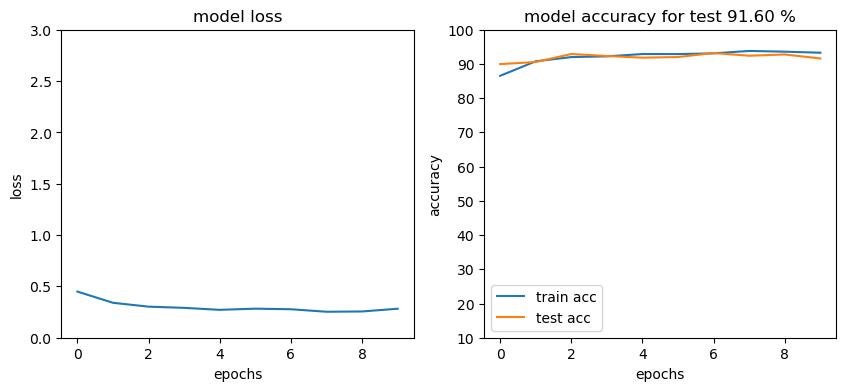

In [56]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(losses)
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylim([0,3])
ax[0].set_title("model loss")

ax[1].plot(trainAcc,label="train acc")
ax[1].plot(testAcc,label="test acc")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_ylim([10,100])
ax[1].set_title(f"model accuracy for test {testAcc[-1]:.2f} %")
ax[1].legend()
plt.show()


In [57]:
yhat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yhat,axis=1)

yhat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yhat,axis=1)

In [58]:
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1],train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1],train_predictions,average="weighted")

test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1],test_predictions,average="weighted")

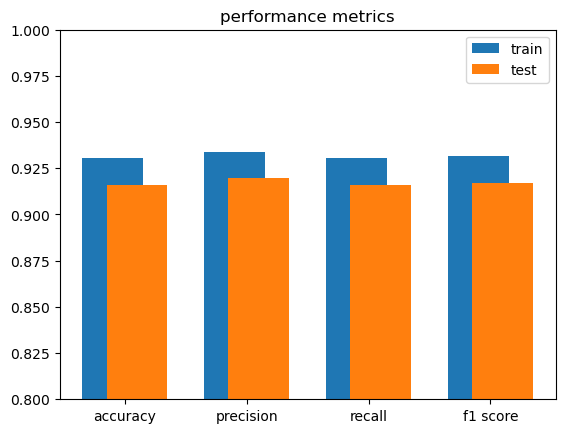

In [59]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],["accuracy","precision","recall","f1 score"])
plt.legend(["train", "test"])
plt.title("performance metrics")
plt.ylim([.8,1])
plt.show()

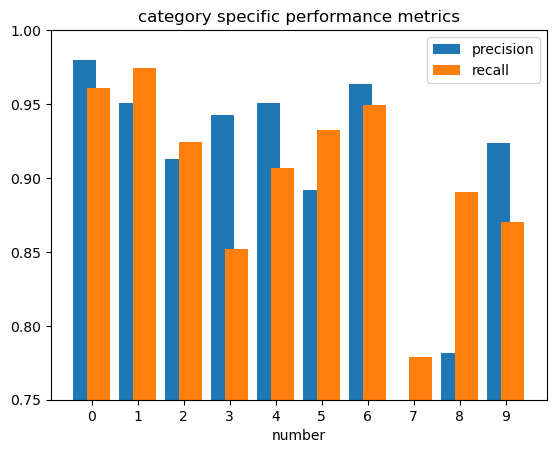

In [62]:
precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall = skm.recall_score(test_loader.dataset.tensors[1],test_predictions,average=None)

plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.legend(["precision", "recall"])
plt.xlabel("number")
plt.title("category specific performance metrics")
plt.ylim([.75,1])
plt.show()